<a href="https://colab.research.google.com/github/wayneotemah/AI-and-ML/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-net model with Tensorflow

# U-Net Image-to-Image Translation with TensorFlow

This notebook demonstrates the implementation of a U-Net model for image-to-image translation using TensorFlow. The U-Net architecture is a popular choice for tasks such as semantic segmentation, style transfer, super-resolution, and more.

## What is U-Net?

U-Net is a convolutional neural network (CNN) architecture designed for image segmentation tasks. It was introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their paper "U-Net: Convolutional Networks for Biomedical Image Segmentation." The U-Net architecture consists of an encoder, a bottleneck, and a decoder, creating a U-shaped network structure.

## Implementation in this Notebook

In this notebook, the U-Net model is implemented using the TensorFlow and Keras API. The specific task demonstrated is image-to-image translation, where the model learns to transform images from one domain to another. The example here focuses on converting color images to grayscale, but the architecture can be adapted for various tasks.

## Notebooks Contents:

1. **Data Preparation:**
   - Loading and preprocessing training and validation data using TensorFlow's ImageDataGenerator.

2. **U-Net Model:**
   - Defining the U-Net architecture for image-to-image translation. The model includes an encoder, a bottleneck, and a decoder.

3. **Training:**
   - Compiling and training the U-Net model on the prepared data.

4. **Testing:**
   - Loading saved weights and using the trained model to make predictions on new or unseen data.

Feel free to adapt the code and experiment with different image-to-image translation tasks by adjusting the model architecture, loss function, and preprocessing steps.

Enjoy experimenting with U-Net for your image translation tasks!

---

*Note: Make sure to replace specific file paths and other parameters as needed for your dataset and use case.*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile


#Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ML Datasets/plant images/4_classes.zip", "r")
zip_ref.extractall()
zip_ref.close()


In [ ]:
train_dir = "4_classes/train/"

In [ ]:
import os
from PIL import Image



# Check each image in your training and validation directories
for folder in [train_dir]:
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            for image_name in os.listdir(subdir_path):
                image_path = os.path.join(subdir_path, image_name)
                try:
                    img = Image.open(image_path)  # open the image file
                    img.verify()  # verify that it is, in fact, an image
                except (IOError, SyntaxError) as e:
                    print('Bad file:', image_path)  # print out the names of corrupt files
                    delete_file = input("Do you want to delete this file? (y/n): ")
                    if delete_file.lower() == 'y':
                        os.remove(image_path)
                        print(f"File {image_path} has been deleted.")
                    else:
                        print("File not deleted.")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
# Preprocess data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # Add validation split

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="input",  # Change class_mode to "input" for U-Net reconstruction
                                               subset='training',  # Specify the subset as training
                                               seed=42,
                                               shuffle=True)

# Validation data
validation_data = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(224, 224),
                                                    class_mode="input",
                                                    subset='validation',  # Specify the subset as validation
                                                    seed=42,
                                                    shuffle=False)  # No need to shuffle validation data

Found 9157 images belonging to 4 classes.
Found 2288 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape=(256, 256, 3)):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.concatenate([conv3, up5], axis=-1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    concat6 = layers.concatenate([conv2, up6], axis=-1)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    concat7 = layers.concatenate([conv1, up7], axis=-1)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate the model
model = unet_model()

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
287/287 [==============================] - 395s 1s/step - loss: 0.0056 - val_loss: 2.8061e-04
Epoch 2/10
287/287 [==============================] - 323s 1s/step - loss: 1.9182e-04 - val_loss: 7.9191e-05
Epoch 3/10
287/287 [==============================] - 318s 1s/step - loss: 1.0141e-04 - val_loss: 6.8195e-05
Epoch 4/10
287/287 [==============================] - 320s 1s/step - loss: 9.8419e-05 - val_loss: 3.7500e-05
Epoch 5/10
287/287 [==============================] - 320s 1s/step - loss: 9.0435e-05 - val_loss: 4.8114e-05
Epoch 6/10
287/287 [==============================] - 318s 1s/step - loss: 8.3514e-05 - val_loss: 3.3118e-05
Epoch 7/10
287/287 [==============================] - 318s 1s/step - loss: 6.2269e-05 - val_loss: 1.0556e-04
Epoch 8/10
287/287 [==============================] - 319s 1s/step - loss: 5.9363e-05 - val_loss: 5.6219e-05
Epoch 9/10
287/287 [==============================] - 320s 1s/step - loss: 4.9910e-05 - val_loss: 1.4481e-04
Epoch 10/10
287/287 [==

In [ ]:
model.save("/content/drive/MyDrive/ML_models/Diffusion/Unet.h5")
model.save_weights("/content/drive/MyDrive/ML_models/Diffusion/Unet_weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_test_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1] (same as during training)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    return img_array




In [ ]:
import matplotlib.pyplot as plt

def plot_results(original, prediction):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze())  # Remove the batch dimension
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')  # Assuming grayscale output, remove the batch dimension
    plt.title('Model Prediction')

    plt.show()

In [ ]:
# Example of how to use the preprocessing function
test_image_path = '/content/leaf-curl-1.jpg'
test_image = preprocess_test_image(test_image_path)

1/1 [==============================] - 0s 28ms/step


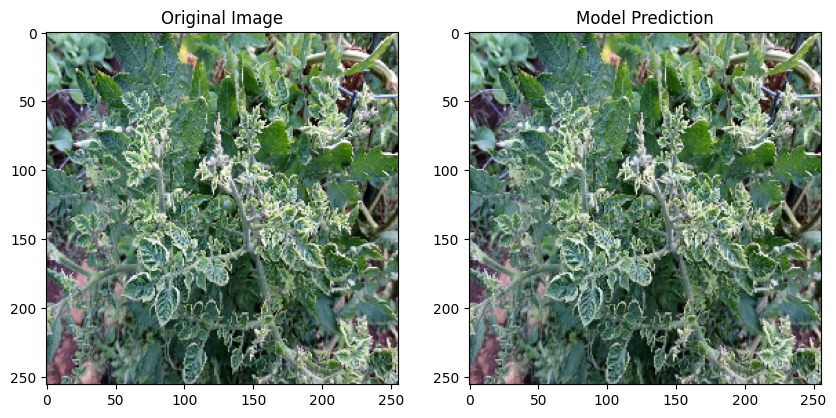

In [ ]:
# Assuming you have already loaded the trained model
prediction = model.predict(test_image)

# Visualize the results
plot_results(test_image.numpy(), prediction)
